# Hip Hop Music Topic Modeling

In [1]:
from getMusicData import *
from process_lyrics import *
import pandas as pd
from pymongo import MongoClient
import collections

client = MongoClient()
music_db = client.music_db
songs = music_db.song_collection

music_df = pd.DataFrame(list(songs.find()))
music_df['processed_lyrics'] = [preprocess_all(lyric) for lyric in music_df['lyrics']]
music_df['decade'] = [int(str(x)[:3]+'0') for x in music_df['year']]
music_df = music_df[music_df['processed_lyrics']!='instrument']
music_df.head()

,_id,acousticness,album,analysis_url,artist,danceability,duration_ms,energy,id,instrumentalness,...,tempo,time_signature,track_href,track_name,type,uri,valence,year,processed_lyrics,decade
0,598ba6d30765e02e52d43a68,0.034600,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/5IR1...,KRS-One,0.668,171293.0,0.573,5IR1BV84fjB5SPzDw5NTQp,0.000578,...,182.223,4.0,https://api.spotify.com/v1/tracks/5IR1BV84fjB5...,KRS-One Attacks,audio_features,spotify:track:5IR1BV84fjB5SPzDw5NTQp,0.711,1993,spoken intro will forev understand forev fore...,1990
1,598ba6d40765e02e52d43a69,0.000298,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/1yjR...,KRS-One,0.849,268907.0,0.757,1yjRkRZ9N9blrca0f0UzeF,0.110000,...,96.374,4.0,https://api.spotify.com/v1/tracks/1yjRkRZ9N9bl...,Outta Here,audio_features,spotify:track:1yjRkRZ9N9blrca0f0UzeF,0.467,1993,* DJ premier samplesscratch vers boogi perform...,1990
2,598ba6d40765e02e52d43a6a,0.022900,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/0i5B...,KRS-One,0.936,179160.0,0.575,0i5BepbSYym7AAIqyOhIxL,0.003320,...,95.481,4.0,https://api.spotify.com/v1/tracks/0i5BepbSYym7...,Black Cop,audio_features,spotify:track:0i5BepbSYym7AAIqyOhIxL,0.698,1993,buck buck buck-buck-buck buck-buck buck buck r...,1990
3,598ba6d50765e02e52d43a6b,0.038000,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/7sBx...,KRS-One,0.914,200000.0,0.615,7sBxvRUzQmF7uB2ZFfjzF3,0.000164,...,96.277,4.0,https://api.spotify.com/v1/tracks/7sBxvRUzQmF7...,Mortal Thought,audio_features,spotify:track:7sBxvRUzQmF7uB2ZFfjzF3,0.822,1993,adjust trebl right now adjust bass turn stop f...,1990
4,598ba6d50765e02e52d43a6c,0.018000,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/0dup...,KRS-One,0.909,214173.0,0.962,0dupEkAq7v5mTay6lJBvRx,0.000000,...,100.694,4.0,https://api.spotify.com/v1/tracks/0dupEkAq7v5m...,I Can't Wake Up,audio_features,spotify:track:0dupEkAq7v5mTay6lJBvRx,0.617,1993,want count ten nine eight seven six five four ...,1990


In [2]:
music_df.columns

Index(['_id', 'acousticness', 'album', 'analysis_url', 'artist',
       'danceability', 'duration_ms', 'energy', 'id', 'instrumentalness',
       'key', 'liveness', 'loudness', 'lyrics', 'mode', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'track_name', 'type', 'uri', 'valence',
       'year', 'processed_lyrics', 'decade'],
      dtype='object')

In [3]:
music_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8033 entries, 0 to 8099
Data columns (total 26 columns):
_id                 8033 non-null object
acousticness        4310 non-null float64
album               8033 non-null object
analysis_url        4310 non-null object
artist              8033 non-null object
danceability        4304 non-null float64
duration_ms         4310 non-null float64
energy              4310 non-null float64
id                  4310 non-null object
instrumentalness    4310 non-null float64
key                 4310 non-null float64
liveness            4308 non-null float64
loudness            4310 non-null float64
lyrics              8033 non-null object
mode                4310 non-null float64
speechiness         4304 non-null float64
tempo               4310 non-null float64
time_signature      4304 non-null float64
track_href          4310 non-null object
track_name          8033 non-null object
type                4310 non-null object
uri                 

### Topic Modeling

Using Gensim LDA and NMF

### Gensim LDA

In [4]:
### Gensim LDA
from gensim import corpora, models, similarities, matutils
from gensim.corpora import Dictionary, MmCorpus

def prep_corpus(docs, no_below=5, no_above=0.5):
    print('Building dictionary...')
    text = [lyric.split(' ') for lyric in list(docs)]
    dictionary = Dictionary(text)
    dictionary.compactify()
    dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=None)
    dictionary.compactify()

    print('Building corpus...')
    corpus = [dictionary.doc2bow(doc.split(' ')) for doc in docs]

    return dictionary, corpus

dict_lda, corp_lda = prep_corpus(list(music_df['processed_lyrics']))

Building dictionary...
Building corpus...


In [5]:
%time lda = models.LdaModel(corpus=corp_lda, num_topics=5, id2word=dict_lda, passes=10)
lda.print_topics(num_words=10)

CPU times: user 3min 53s, sys: 1.96 s, total: 3min 55s
Wall time: 4min


[(0,
  '0.015*"never" + 0.014*"renegad" + 0.014*"shine" + 0.013*"hop" + 0.013*"hip" + 0.011*"day" + 0.011*"right" + 0.008*"flash" + 0.008*"funk" + 0.007*"look"'),
 (1,
  '0.038*"love" + 0.023*"feel" + 0.016*"said" + 0.016*"girl" + 0.015*"beat" + 0.015*"look" + 0.013*"never" + 0.013*"thought" + 0.013*"perfect" + 0.013*"let"'),
 (2,
  '0.013*"wrap" + 0.008*"smell" + 0.006*"girl" + 0.006*"fli" + 0.006*"cold" + 0.006*"think" + 0.006*"new" + 0.006*"gonna" + 0.005*"use" + 0.005*"call"'),
 (3,
  '0.034*"rock" + 0.021*"jump" + 0.016*"lover" + 0.014*"stop" + 0.010*"everybodi" + 0.010*"hous" + 0.010*"big" + 0.009*"caddi" + 0.009*"girl" + 0.008*"parti"'),
 (4,
  '0.010*"bword" + 0.006*"money" + 0.006*"\'em" + 0.005*"y\'all" + 0.005*"want" + 0.005*"wanna" + 0.005*"ass" + 0.004*"keep" + 0.004*"right" + 0.004*"put"')]

### Using NMF

In [6]:
### NMF Approach
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import NMF

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def nmf_model(music_df, n_topics):
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df = 50, max_df = 0.5,
                                       stop_words='english', token_pattern="\\b[a-z][a-z]+\\b")

    dtm = vectorizer.fit_transform(music_df['processed_lyrics'])
    feature_names = vectorizer.get_feature_names()

    nmf_model = NMF(n_topics, random_state=444)
    print('Fitting NMF...')
    dtm_nmf = nmf_model.fit_transform(dtm)
    dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)
    print('Shape: ', dtm_nmf.shape)
    display_topics(nmf_model, feature_names, 20)
    return dtm_nmf

In [7]:
n_topics = 5
dtm_nmf = nmf_model(music_df, n_topics)

Fitting NMF...
Shape:  (8033, 5)
Topic 0:
life black em live peopl god day tri way right rhyme world rock said gotta feel mind rap let think
Topic 1:
love babi love love girl feel want need right wanna let heart tell good babi babi thing night way said gon think
Topic 2:
bword money hoe ass lil em dword babi nigga bitch pword dogg snoop big bout fuck fwordin want boy wit
Topic 3:
cube ice cube ice ass yo gangsta west motherfword fool lench coast motherfwordin punk wanna ms west coast lench mob littl mob gangsta sword
Topic 4:
nwordz dog wit niggaz motherfword uh gon mon ass huh uh huh fwordin em yo street busta gun motherfwordin real cat


In [8]:
#music_df[music_df['artist']=='Ice Cube']

In [9]:
#print(music_df['lyrics'][7845])

for topic in range(n_topics):
    count=0
    for x in dtm_nmf:
        if x.argmax() == topic:
            count+=1
    print('Topic {}:'.format(topic), count, 'songs on this topic')

Topic 0: 3647 songs on this topic
Topic 1: 1026 songs on this topic
Topic 2: 2162 songs on this topic
Topic 3: 340 songs on this topic
Topic 4: 858 songs on this topic


In [10]:
topic_map = {'Topic 1': 'Thoughts/Brotherhood', 'Topic 2': 'Love/Feelings', 'Topic 3': 'Sexual',
              'Topic 4': 'Ice Cube?', 'Topic 5': 'Gangs/Money'}

In [11]:
columns = []
x=1
for topic in range(n_topics):
    columns.append('Topic {}'.format(x))
    x+=1
columns = [topic_map[x] for x in columns]
topic_df = pd.DataFrame(dtm_nmf, columns=columns)
topic_df.head()

,Thoughts/Brotherhood,Love/Feelings,Sexual,Ice Cube?,Gangs/Money
0,0.955093,0.296305,0.000000,0.000000,0.000000
1,0.998788,0.049215,0.000000,0.000000,0.000000
2,0.952673,0.000000,0.000000,0.283691,0.109240
3,0.999461,0.000000,0.000000,0.000000,0.032824
4,0.847155,0.000000,0.511423,0.014108,0.143442


In [12]:
songs_and_topics = music_df.join(topic_df)
songs_and_topics.head(3)

,_id,acousticness,album,analysis_url,artist,danceability,duration_ms,energy,id,instrumentalness,...,uri,valence,year,processed_lyrics,decade,Thoughts/Brotherhood,Love/Feelings,Sexual,Ice Cube?,Gangs/Money
0,598ba6d30765e02e52d43a68,0.034600,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/5IR1...,KRS-One,0.668,171293.0,0.573,5IR1BV84fjB5SPzDw5NTQp,0.000578,...,spotify:track:5IR1BV84fjB5SPzDw5NTQp,0.711,1993,spoken intro will forev understand forev fore...,1990,0.955093,0.296305,0.0,0.000000,0.00000
1,598ba6d40765e02e52d43a69,0.000298,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/1yjR...,KRS-One,0.849,268907.0,0.757,1yjRkRZ9N9blrca0f0UzeF,0.110000,...,spotify:track:1yjRkRZ9N9blrca0f0UzeF,0.467,1993,* DJ premier samplesscratch vers boogi perform...,1990,0.998788,0.049215,0.0,0.000000,0.00000
2,598ba6d40765e02e52d43a6a,0.022900,Return of the Boom Bap,https://api.spotify.com/v1/audio-analysis/0i5B...,KRS-One,0.936,179160.0,0.575,0i5BepbSYym7AAIqyOhIxL,0.003320,...,spotify:track:0i5BepbSYym7AAIqyOhIxL,0.698,1993,buck buck buck-buck-buck buck-buck buck buck r...,1990,0.952673,0.000000,0.0,0.283691,0.10924


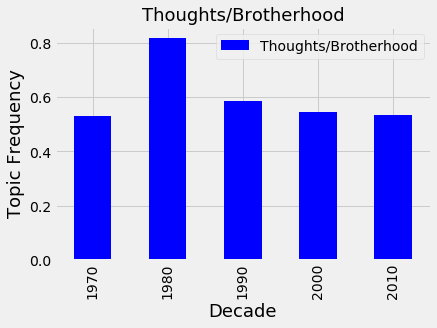

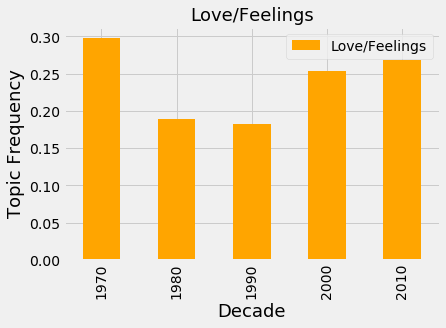

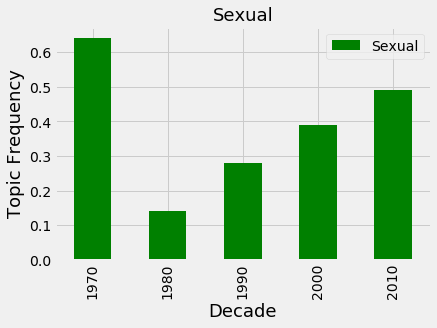

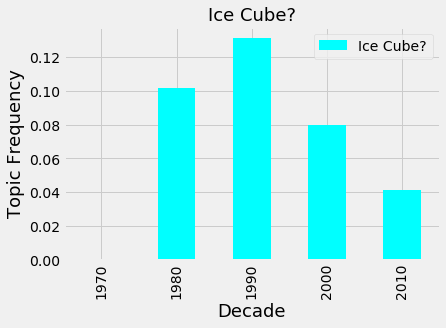

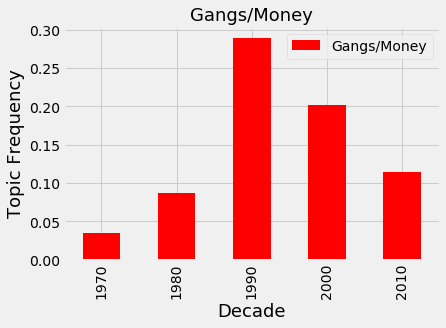

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

decades = list(songs_and_topics['decade'].unique())
#decades = ['1980', '1990', '2000', '2010']
colors = ['blue', 'orange', 'green', 'cyan','red']
plt.style.use('fivethirtyeight')
for topic, color in zip(columns,colors):
    cols = [topic, 'decade']
    df = songs_and_topics#[songs_and_topics['decade']!=1970]
    df = df[cols].groupby('decade').mean()
    df.plot(kind='bar', color = color)
    plt.xlabel('Decade', fontsize=18)
    plt.ylabel('Topic Frequency', fontsize=18)
    plt.title(str(topic), fontsize=18)

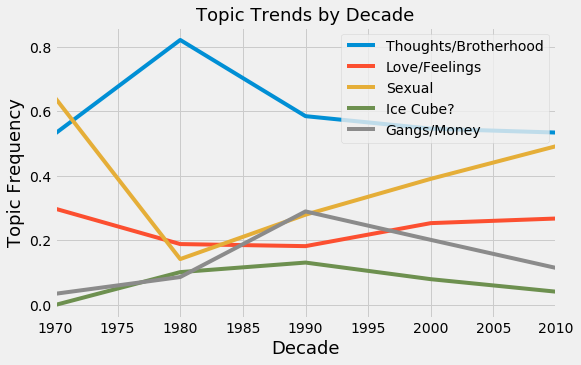

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

columns.append('decade')
df = songs_and_topics[columns].groupby('decade').mean()
df.plot()
plt.title('Topic Trends by Decade', fontsize=18)
plt.xlabel('Decade', fontsize=18)
plt.ylabel('Topic Frequency', fontsize=18)

In [15]:
columns

['Thoughts/Brotherhood',
 'Love/Feelings',
 'Sexual',
 'Ice Cube?',
 'Gangs/Money',
 'decade']

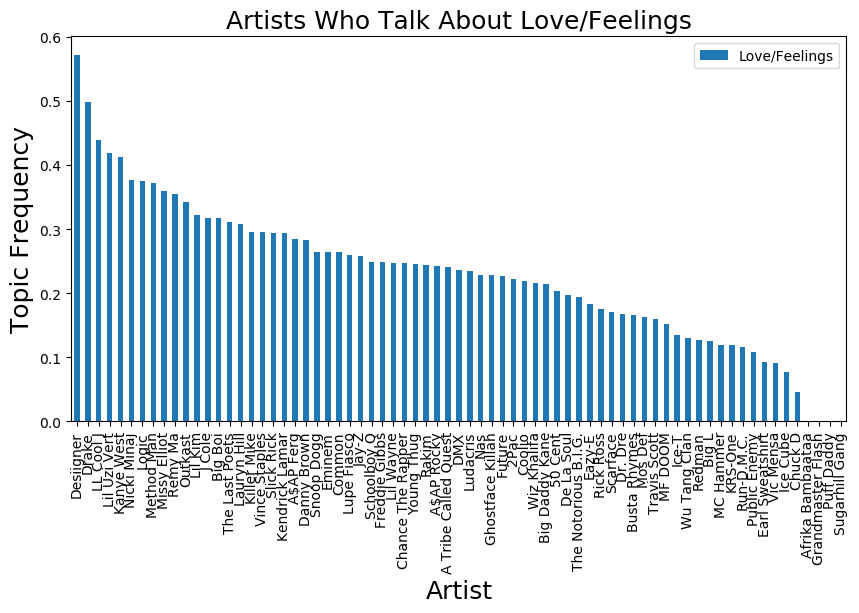

In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
rcParams['figure.figsize'] = 10, 5
df = songs_and_topics[['artist', 'Love/Feelings']].groupby('artist').mean()
df = df.sort_values('Love/Feelings', ascending=False)
df.plot(kind='bar')
plt.title('Artists Who Talk About Love/Feelings', fontsize=18)
plt.xlabel('Artist', fontsize=18)
plt.ylabel('Topic Frequency', fontsize=18)

In [17]:
songs_and_topics.to_csv('songs_and_topics.csv', index=False)

# pyLDAvis

Visualizing the topics

In [18]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis.sklearn
import pyLDAvis
pyLDAvis.enable_notebook()

vis_data = gensimvis.prepare(lda, corp_lda, dict_lda)
#vis_data = pyLDAvis.sklearn.prepare(nmf_model, dtm_tfidf, tfidf_vectorizer)
pyLDAvis.display(vis_data)

## Topics Over Time

In [19]:
music_df['decade'] = [int(str(x)[:3]+'0') for x in music_df['year']]

# 70's Topics

In [20]:
#70's 
df_70 = music_df[music_df['decade']==1970]
dict_70, corp_70 = prep_corpus(list(df_70['processed_lyrics']))
%time lda_70 = models.LdaModel(corpus=corp_70, num_topics=7, id2word=dict_70, passes=10)
vis_data = gensimvis.prepare(lda_70, corp_70, dict_70)
pyLDAvis.display(vis_data)

Building dictionary...
Building corpus...
CPU times: user 1.05 s, sys: 8.51 ms, total: 1.06 s
Wall time: 1.06 s


# 80's Topics

In [21]:
#80's 
df_80 = music_df[music_df['decade']==1980]
dict_80, corp_80 = prep_corpus(list(df_80['processed_lyrics']))
%time lda_80 = models.LdaModel(corpus=corp_80, num_topics=7, id2word=dict_80, passes=10)
vis_data = gensimvis.prepare(lda_80, corp_80, dict_80)
pyLDAvis.display(vis_data)

Building dictionary...
Building corpus...
CPU times: user 35.5 s, sys: 339 ms, total: 35.9 s
Wall time: 37.8 s


# 90's Topics

In [22]:
#90's 
df_90 = music_df[music_df['decade']==1990]
dict_90, corp_90 = prep_corpus(list(df_90['processed_lyrics']))
%time lda_90 = models.LdaModel(corpus=corp_90, num_topics=7, id2word=dict_90, passes=10)
vis_data = gensimvis.prepare(lda_90, corp_90, dict_90)
pyLDAvis.display(vis_data)

Building dictionary...
Building corpus...
CPU times: user 1min 5s, sys: 511 ms, total: 1min 6s
Wall time: 1min 7s


# 2000's Topics

In [23]:
#2000's 
df_2000 = music_df[music_df['decade']==2000]
dict_2000, corp_2000 = prep_corpus(list(df_2000['processed_lyrics']))
%time lda_2000 = models.LdaModel(corpus=corp_2000, num_topics=7, id2word=dict_2000, passes=10)
vis_data = gensimvis.prepare(lda_2000, corp_2000, dict_2000)
pyLDAvis.display(vis_data)

Building dictionary...
Building corpus...
CPU times: user 5min 8s, sys: 2.69 s, total: 5min 10s
Wall time: 5min 17s


# 2010's Topics

In [24]:
#2010's 
df_10 = music_df[music_df['decade']==2010]
dict_10, corp_10 = prep_corpus(list(df_10['processed_lyrics']))
%time lda_10 = models.LdaModel(corpus=corp_10, num_topics=7, id2word=dict_10, passes=10)
vis_data = gensimvis.prepare(lda_10, corp_10, dict_10)
pyLDAvis.display(vis_data)

Building dictionary...
Building corpus...
CPU times: user 1min 46s, sys: 704 ms, total: 1min 47s
Wall time: 1min 49s
